In [1]:
#Library
import requests
import json
from datetime import datetime
import scipy.optimize as optimize
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 12)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(endpointApi, date=None, full_response=False, columns=list()):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    
    payload = {'date': date, 'fullResponse': full_response}
    res = requests.get(URL + endpointApi,
                      params=payload,
                      auth=AUTH,
                      verify=False)
    return res.content.decode('utf-8')

In [3]:
def put_data(endpointApi, content):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    
    res = requests.put(url=URL + endpointApi,
                      data=json.dumps(content),
                      auth=AUTH,
                      headers = {"content-type": "application/json"},
                      verify=False)
    return res.content.decode('utf-8')

In [4]:
def post_data(endpointApi, content):
    URL = 'https://dolphin.jump-technology.com:8443/api/v1/'
    AUTH = ('EPITA_GROUPE10', 'LRNSpHqMgGv86AH5')
    
    res = requests.post(url=URL + endpointApi,
                      data=json.dumps(content),
                      auth=AUTH,
                      headers = {"content-type": "application/json"},
                      verify=False)
    return res.content.decode('utf-8')

Conversion chaque valeur en le type approprié :

In [5]:
def convert_currency(value, df_convert_currency):
    value, currency_name = value.split(' ')
    rate = currencyRateToEUR(currency_name, df_currency_rate)
    
    new_value = float(value.replace(',', '.')) * rate
    return new_value

def convert_datetime(value):
    return datetime.strptime(value, '%Y-%m-%d').date()

def convert_float(value):
    return float(value.replace(',', '.'))

def convert_int(value):
    return int(value)

def convert_boolean(value):
    return json.loads(value)

def df_convert_type(df, df_currency_rate):
        for col in df.columns:
            convert_values = []
            for elt in df[col]:
                if elt is np.nan:
                    convert_values.append(np.nan)
                    continue

                elt_type = elt['type']
                elt_value = elt['value']
                if elt_type == 'currency_value':
                    elt_value = convert_currency(elt_value, df_currency_rate)
                elif elt_type == 'date':
                    elt_value = convert_datetime(elt_value)
                elif elt_type in ['double', 'percent']:
                    elt_value = convert_float(elt_value)
                elif elt_type in ['asset', 'int32']:
                    elt_value = convert_int(elt_value)
                elif elt_type == 'boolean':
                    elt_value = convert_boolean(elt_value)
                elif elt_type not in ['asset_type', 'string', 'asset_currency', 'date-time',
                                     'asset_sub_type', 'asset_status', 'asset_quote_type',
                                     'liquidity_algorithm', 'portfolio_lock_mode', 'portfolio_type']:
                    print(elt)
                convert_values.append(elt_value)
            df[col] = convert_values
        return df

Création de la table des taux en EUR : 
 
[Est-ce qu'on donne la posibilité de changer la currency dst en fonction de la currency du portfolio ?]

In [6]:
def getCurrencyRate():
    d = []
    currency_json = json.loads(get_data('currency'))
    for currency in currency_json:
        currency_id = currency.get('id')
        rate = get_data('currency/rate/{}/to/EUR'.format(currency_id))
        if len(rate) == 0:
            continue
        rate_value = json.loads(rate)['rate']['value']
        d.append([currency_id, convert_float(rate_value)])
    return pd.DataFrame(d, columns=['currency src', 'rate'])
    
df_currency_rate = getCurrencyRate()
df_currency_rate

,currency src,rate
0,USD,0.851208716377
1,EUR,1.000000000000
2,JPY,0.008066467694
3,BEF,0.024789352477
4,CYP,1.708601441376
5,EEK,0.063911648537
6,MTL,2.329373398556
7,SKK,0.033193918874
8,USN,0.851208716377
9,USS,0.851208716377


[TEST] Taux de convertion entre USD et EUR :

In [7]:
def currencyRateToEUR(cur_src, df_currency_rate):
    return df_currency_rate[df_currency_rate['currency src'] == cur_src]['rate'].values[0]
rate = currencyRateToEUR('USD', df_currency_rate)
rate


0.851208716377

[TEST] La database complète de tous les asset :

In [8]:
data = get_data('asset/')
df = pd.read_json(data)
df_assets = df_convert_type(df, df_currency_rate)
df_asset_1954 = df_assets[df_assets['ASSET_DATABASE_ID'] == 1954]
df_asset_1954

,SECTOR,TYPE,quote_value_type,MARKET_PLACE_CITY,BLOOMBERG_CODE,MARKET_PLACE_TYPE,SUP_SECTOR,VL_DELAY,IS_DEPOSITARY_QUOTES,IS_STRUCTURED_PRODUCT,ASSET PRICE MODE,INDEXED_RATE,COUNTRY_CIC,IS_EURONEXT,QUOTE_TYPE,IS_ACCESSIBILITY_PUBLIC,PORT_CONTENT_COUNT,LAST_CLOSE_VALUE_IN_CURR,LIQUIDITY_ALGO,EMIR_CLEARING_ID_TYPE,MARKET_PLACE,CREATION_DATE,CURRENCY,IS_FUND_SAVE_SENS,PORT_LINE_COUNT,IS_EUROLAND,SUB_TYPE,SUB_SECTOR,SEDOL_CODE,GRAPH_LAST_YEAR,GRAPH_PAST_WEEK,GICS_SECTOR,MARKET_PLACE_CURRENCY,GRAPH_LAST_6_MONTH,FLOATING_VALUE,asset_custom_classification_bloomberg,LAST_QUOTE_SOURCE,MARKET_PLACE_MIC,GICS_INDUSTRY,REST_UNIQUE_NUMBER,CODE_CIC,DAILY_PRICE_COUNT,MODIFICATION_DATE,SUB_CATEGORY_CIC,IS_PUBLICLY_TRADED,FINAL_UNDERLYING,IS_COMPOSITE,UNDERLYING_OR_ASSET_IF_UNDERLYING_NOT_AVAILABLE,BLOOMBERG_ID,MARKET_PLACE_COUNTRY,GICS_INDUSTRY_GROUP,ASSET_DATABASE_ID,ISIN_CODE,INDUSTRY,MARKET_PLACE_TELEKURS,LAST_CLOSE_VALUE,PAY_ACCOUNT_ON_DEFAULT,IS_FUND_FED,LAST_QUOTES_UPDATE_DATE,LAST_GROSS_VALUE,MARKET_CAP_CATEGORY,FINAL_UNDERLYING_TYPE,MARKET_PLACE_OR_ASSET_COUNTRY,CATEGORY_CIC,GRAPH_PAST_YEAR,REST_OBJECT_ID,GRAPH_PERIOD,LAST_QUOTE_DATE,GLOBAL_TYPE,COUNTRY,STOCK_TYPE,GICS_SUB_INDUSTRY,MARKET_PLACE_DESC,ASSET_OR_MARKET_PLACE_COUNTRY,LABEL,asset_attr_init,FIRST_QUOTE_DATE,CITY_OR_ACRONYM_OR_NAME,IS_PORTFOLIO,ASSET_STATUS,COUNTRY_ISO_3,asset_custom_classification_Tab. de bord GSM,ELIGIBLE_PEA,ELIGIBLE_PEA_PME,ASSET_MARKET_SUB_GROUP,IS_REAL_ESTATE_FUND,asset_fund_info_isin_code,asset_fund_info_objective_long,asset_fund_info_cut_off,BOND_YTM_COMPUTATION_MODE,asset_fund_info_administrator,asset_fund_info_manager_stated_perf_fee,BOND_CREDIT_RISK_COMPUTATION_MODE,asset_fund_info_authorized_for_retail_investors,BOND_WAL_COMPUTATION_MODE,FUND_TYPE,asset_fund_info_creation_date,asset_fund_info_vl_date,asset_fund_info_is_feeded,asset_fund_info_is_euro_ucits,asset_fund_info_asset_class_focus,BOND_WAM_COMPUTATION_MODE,BOND_RISK_COMPUTATION_MODE,asset_fund_info_maximum_front_end_fee,asset_fund_info_strategy,asset_fund_info_manager_stated_fee,asset_fund_info_valorisation_frequency,asset_fund_info_auditor,asset_fund_info_fund_leverage,asset_fund_info_maximum_back_end_fee,asset_fund_info_fund_type,TRANSPARENCY_LIST,asset_fund_info_minimum_investment_shares,asset_fund_info_bloomberg_ticker,asset_fund_info_company,asset_fund_info_depositary,MIN_BUY_AMOUNT,asset_fund_info_subscription_committee,asset_fund_info_geographical_focus,MIN_BUY_INITIAL_AMOUNT,asset_fund_info_day_cut_off,asset_fund_info_minimum_subscription,asset_fund_info_vl_known,asset_fund_info_pct_max_opcvm,asset_fund_info_initial_minimum_subscription,asset_fund_info_fund_open_pymt_shr,asset_fund_info_amf_date,asset_fund_info_decimalisation,asset_fund_info_amf_classification,asset_fund_info_abide_with_the_four_criterias,asset_fund_info_reuters_code,REUTERS_CODE,asset_fund_info_subscription_frequency,asset_fund_info_redemption_frequency,VALOREN_CODE,asset_fund_info_valoren_code,asset_fund_info_manager,asset_fund_info_redemption_committee,asset_fund_info_advised_horizon,FUND_REF_IDX,asset_fund_info_comanager,HAS_TOBIN_TAX,CUSIP_CODE,LOCAL_CODE,asset_fund_info_rate_entry_sdg,asset_fund_info_rate_output_sdg,asset_fund_info_rate_entry,asset_fund_info_rate_output,asset_fund_info_management_style,MARKET_QUOTE_IDENTIFIER,asset_fund_info_manager_committee,PORT_ASSET_CONTENT_COUNT,INDEX_TYPE,QUOTE_PLACE,TELEKURS_QUOTE_PLACE_CODE,IS_SRD,LOCK_MODE,PORT_NET_EX_CASH_EQUIVALENT,PORT_NET_EX_CASH,EAI_PORT_AVAILABLE_CASH,NB_COMPTE_ON_PORTFOLIO,PORT_IS_HISTORICAL,PORT_STATUS,PORT_CASH_EQUIVALENTS,PORT_CLEAN_MODE,EAI_PORTFOLIO_FEED_NAME,PORT_BASE_NAV,PORT_FEED_CODE,PORT_CURRENCY_HEDGE,PORT_FIRST_TRANSACTION,PORT_NEED_RECONCILIATION,REAL_TIME_PORT_CASH,PRICER_MODE,PORT_VL,EAI_FRONTPORT_CASH_BY_CRCY,PORT_CASH_AVAILABLE,PORT_FEED_TYPE,PORT_TYPE,EAI_BACKPORT_CASH_BY_CRCY,PORT_CASH,VL_DELAY_VALUE,PORT_RATING_MOODYS_SHORT_TERM,PORT_PERCENT_CASH_AVAILABLE,PORT_RATING_SP_SHORT_TERM,PORT_RATING_MOODYS,PORT_RATING_SP,PORT_PERC

Récupération de la liste d'actifs en base :

[On prend juste ces valeurs comme dans l'exemple ou toutes les valeurs des assets ?]

In [9]:
def get_df_asset(asset_date, df_currency_rate, asset_id='ASSET_DATABASE_ID', asset_label='LABEL',
                 asset_type='TYPE', asset_last_close_value='LAST_CLOSE_VALUE_IN_CURR'):
    data = get_data('asset?columns={}&columns={}&columns={}&columns={}&date={}&columns=CREATION_DATE'
                   .format(asset_id, asset_label, asset_type, asset_last_close_value, asset_date))
    df_asset = pd.read_json(data)
    df_asset = df_convert_type(df_asset, df_currency_rate)
    df_asset = df_asset[(df_asset['LAST_CLOSE_VALUE_IN_CURR'].notna()) | (df_asset['TYPE'] == 'PORTFOLIO')].reset_index() #FIXME es assets avec LAST_CLOSE_VALUE_IN_CURR = NAN bug lors de l'ajout dans un portefeuille
    return df_asset

df_ETF = get_df_asset('2016-06-01', df_currency_rate)
df_ETF

,index,TYPE,ASSET_DATABASE_ID,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,LABEL
0,0,STOCK,1845,3.685100000000e+01,2019-10-02,1&1 DRILLISCH AG
1,1,STOCK,1846,4.090000000000e+01,2019-10-02,1000MERCIS
2,2,FUND,2122,3.937000000000e+01,2019-10-02,1818-VEGA EUR CO
3,3,FUND,2123,1.670650000000e+03,2019-10-02,29 HAUSSMANN CROISSANCE EUROPE D
4,6,STOCK,1847,3.170000000000e+01,2019-10-02,AALBERTS INDS
5,7,STOCK,1848,3.281000000000e+01,2019-10-02,AAREAL BANK AG
6,8,STOCK,1849,6.730000000000e+00,2019-10-02,ABC ARBITRAGE
7,9,FUND,2154,1.786653047327e+01,2019-10-02,ABERDEEN CHINA EQUITY A2
8,13,FUND,2156,3.371237657473e+01,2019-10-02,ABERDEEN GLOBAL - EMERGING MARKETS BOND - A AC...
9,14,FUND,2127,1.176730000000e+01,2019-10-02,ABER-GL JP E-A2=


Différence entre LAST_CLOSE_VALUE_IN_CURR et LAST_CLOSE_VALUE ??

Récupération des valeurs de cotation:

Cotation de l'actif 1845 en fonction de l'id et de la date de debut et fin :

In [10]:
def get_cotation_values(asset_id, start_date, end_date, df_currency_rate):
    data = get_data('asset/{}/quote?start_date={}&end_date={}'
                    .format(asset_id, start_date, end_date))
    df_cotation = pd.read_json(data)
    df_cotation = df_convert_type(df_cotation, df_currency_rate)
    return df_cotation

df_cotation = get_cotation_values('1845', '2016-06-01', '2020-09-30', df_currency_rate)
df_cotation
    

,date,nav,gross,volume,high,real_close_price,feed_source,low,ask,asset,pl,bid,close,return,open
0,2016-06-01,36.851000000000,36.851000000000,143199.0,37.125,36.851000000000,-10.0,36.675,36.799,1845,0.037000000000,36.723,36.851000000000,0.001005052426,36.745
1,2016-06-02,36.900000000000,36.900000000000,147480.0,37.145,36.900000000000,-10.0,36.594,36.999,1845,0.049000000000,36.946,36.900000000000,0.001329678978,36.786
2,2016-06-03,36.052000000000,36.052000000000,190934.0,37.200,36.052000000000,-10.0,35.800,36.277,1845,-0.848000000000,36.219,36.052000000000,-0.022981029810,36.900
3,2016-06-06,36.540000000000,36.540000000000,82279.0,36.775,36.540000000000,-10.0,36.082,36.587,1845,0.488000000000,36.534,36.540000000000,0.013536003550,36.190
4,2016-06-07,37.246000000000,37.246000000000,119105.0,37.347,37.246000000000,-10.0,36.470,37.172,1845,0.706000000000,37.150,37.246000000000,0.019321291735,36.590
5,2016-06-08,37.127000000000,37.127000000000,84371.0,37.400,37.127000000000,-10.0,37.055,37.115,1845,-0.119000000000,37.078,37.127000000000,-0.003194973957,37.130
6,2016-06-09,36.263000000000,36.263000000000,107502.0,37.188,36.263000000000,-10.0,36.037,36.351,1845,-0.864000000000,36.259,36.263000000000,-0.023271473591,37.110
7,2016-06-10,35.369000000000,35.369000000000,146126.0,36.260,35.369000000000,-10.0,35.300,35.310,1845,-0.894000000000,35.287,35.369000000000,-0.024653227808,36.200
8,2016-06-13,34.907000000000,34.907000000000,244656.0,35.460,34.907000000000,-10.0,34.300,34.962,1845,-0.462000000000,34.904,34.907000000000,-0.013062286183,35.100
9,2016-06-14,33.800000000000,33.800000000000,206910.0,35.033,33.800000000000,-10.0,33.638,33.823,1845,-1.107000000000,33.699,33.800000000000,-0.031712836967,34.750


Récupération de la liste des ratios :

In [11]:
def get_ratio(df_currency_rate):
    data = get_data('ratio')
    df_ratio = pd.read_json(data)
    return df_ratio

df_ratio = get_ratio(df_currency_rate)
df_ratio

,id,type,name,is_benchmark_needed,is_percent
0,11,Ratio,Correlation,True,False
1,7,Ratio,Exposition action,False,True
2,15,Ratio,Exposition action,False,True
3,8,Ratio,RDT,False,True
4,13,Ratio,Rendement,False,True
5,9,Ratio,Rendement_annualise,False,True
6,12,Ratio,Sharpe,False,False
7,14,Ratio,VaR historique,False,True
8,10,Ratio,Volatilite,False,True


Calcul de ratios :

In [12]:
def post_ratio(ratios, assets_id, start_date, end_date, bench=None, frequency=None):
    start_date = datetime.strptime(start_date, "%Y-%m-%d").isoformat()
    end_date = datetime.strptime(end_date, "%Y-%m-%d").isoformat()
    
    payload = {'ratio':ratios, 'asset':assets_id, 'startDate':[start_date], 'endDate':[end_date], 'benchmark':bench, 'frequency':frequency}
    reponse = post_data('ratio/invoke', payload)
    return reponse
    
#get Rendement_annualise, Sharpe, Volatilite, Rendement de l'asset 1845 et 1991 entre '2016-06-01' et '2020-09-30'
post_ratio([9, 12, 10, 13], [1845, 1991], '2016-06-01', '2020-09-30')

'{"1991":{"13":{"type":"percent","value":"-0,423092200656"},"9":{"type":"percent","value":"-0,021028693405"},"12":{"type":"double","value":"-0,038585805536"},"10":{"type":"percent","value":"0,67456654186"}},"1845":{"13":{"type":"percent","value":"1,078534627319"},"9":{"type":"percent","value":"0,028672338605"},"12":{"type":"double","value":"0,076667365134"},"10":{"type":"percent","value":"0,308766820977"}}}'

In [13]:
def get_df_ratios(assets_id, begin_date, end_date):
    json_ratios = json.loads(post_ratio([10, 12, 13], assets_id, begin_date, end_date))
    ratios = []
    for asset_id in assets_id:
        str_asset_id = str(asset_id)
        volatilite = convert_float(json_ratios[str_asset_id]['10']['value'])
        sharpe = convert_float(json_ratios[str_asset_id]['12']['value'])
        rendement = convert_float(json_ratios[str_asset_id]['13']['value'])
        ratios.append([asset_id, volatilite, rendement, sharpe])
    return pd.DataFrame(ratios, columns=['ASSET_DATABASE_ID', 'volatilite', 'rendement', 'sharpe'])


Recupération du portfolio ID :

In [14]:
def get_portfolio_id(df_assets, label):
    portfolio_id = df_assets.loc[(df_assets['TYPE'] == 'PORTFOLIO') & (df_assets['LABEL'] == label)]['REST_OBJECT_ID'].values[0]
    return int(portfolio_id)



portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
portfolio_id_ref = get_portfolio_id(df_assets, 'REF')
print('notre portefeuille id : {}\nréférence portefeuille id : {}'.format(portfolio_id, portfolio_id_ref))

notre portefeuille id : 1829
référence portefeuille id : 2201


Récupération de la composition d’un portefeuille : 

In [15]:
def get_portfolio(portfolio_id):
    data = get_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id))
    df_portfolio = pd.read_json(data)
    return df_portfolio

df_portfolio = get_portfolio(portfolio_id)
df_portfolio

,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN
2016-06-01,EPITA_PTF_10,NaN,front,"[{'asset': {'asset': 2112, 'quantity': 10000.0..."


Get assets from portfolio :

In [16]:
def get_assets_portfolio(df_portfolio, date):
    if date not in df_portfolio['values']:
        return np.NaN
    return df_portfolio['values'][date]

assets = get_assets_portfolio(df_portfolio, '2016-06-01')
assets

[{'asset': {'asset': 2112, 'quantity': 10000.0}},
 {'asset': {'asset': 1521, 'quantity': 10000.0}},
 {'asset': {'asset': 1971, 'quantity': 10000.0}},
 {'asset': {'asset': 1956, 'quantity': 10000.0}},
 {'asset': {'asset': 1990, 'quantity': 10000.0}},
 {'asset': {'asset': 2024, 'quantity': 10000.0}},
 {'asset': {'asset': 1485, 'quantity': 10000.0}},
 {'asset': {'asset': 1597, 'quantity': 10000.0}},
 {'asset': {'asset': 1583, 'quantity': 10000.0}}]

MAJ de la composition d’un portefeuille :


In [17]:
def portfolio_json_assets(assets):
    json = ''
    for asset in assets:
        json += '{{"asset":{{"asset": {}, "quantity": {}}}}},'.format(asset["asset"]["asset"], asset["asset"]["quantity"])
    return json[:-1]
    
def seralize_portfolio_content(df_portfoliot, assets):
    label = df_portfoliot['label'][0]#"EPITA_PTF_10"
    currency = df_portfoliot['currency'][0]#"EUR"
    type_ = df_portfoliot['type'][0]
    date = '2016-06-01' #osef de df_portfolio['date'][0] car cf fiche technique : 
    #"La date de la composition. Pour rappel votre composition doit être unique et doit dater du 2013-06-14"
    assets = portfolio_json_assets(assets) 
    res = '{{"label": "{}", "currency": {{"code": "{}"}}, "type": "{}", "values": {{"{}": [{}]}}}}'.format(label, currency, type_, date, assets)
    return json.loads(res)

def deseralize_portfolio_content(json_portfolio):
    json_portfolio = pd.json_normalize(json_portfolio)
    
    cols = [col for col in json_portfolio.columns if col.split('.')[0] == 'values']
    json_portfolio = json_portfolio[cols]
    json_portfolio.columns = json_portfolio.columns.map(lambda x: x.split(".")[0])

    json_assets = json_portfolio['values'][0]
    assets = []
    for asset in json_assets:
        assets.append(asset)
    return assets


json_portfolio = seralize_portfolio_content(df_portfolio, assets)
print(json_portfolio)

assets = deseralize_portfolio_content(json_portfolio)
assets

{'label': 'EPITA_PTF_10', 'currency': {'code': 'EUR'}, 'type': 'front', 'values': {'2016-06-01': [{'asset': {'asset': 2112, 'quantity': 10000.0}}, {'asset': {'asset': 1521, 'quantity': 10000.0}}, {'asset': {'asset': 1971, 'quantity': 10000.0}}, {'asset': {'asset': 1956, 'quantity': 10000.0}}, {'asset': {'asset': 1990, 'quantity': 10000.0}}, {'asset': {'asset': 2024, 'quantity': 10000.0}}, {'asset': {'asset': 1485, 'quantity': 10000.0}}, {'asset': {'asset': 1597, 'quantity': 10000.0}}, {'asset': {'asset': 1583, 'quantity': 10000.0}}]}}


[{'asset': {'asset': 2112, 'quantity': 10000.0}},
 {'asset': {'asset': 1521, 'quantity': 10000.0}},
 {'asset': {'asset': 1971, 'quantity': 10000.0}},
 {'asset': {'asset': 1956, 'quantity': 10000.0}},
 {'asset': {'asset': 1990, 'quantity': 10000.0}},
 {'asset': {'asset': 2024, 'quantity': 10000.0}},
 {'asset': {'asset': 1485, 'quantity': 10000.0}},
 {'asset': {'asset': 1597, 'quantity': 10000.0}},
 {'asset': {'asset': 1583, 'quantity': 10000.0}}]

[A CHECK le JSON de put_portfolio]

In [18]:
def put_portfolio(portfolio_id, df_portfolio, assets):
    content = seralize_portfolio_content(df_portfolio, assets)
    print(content)
    put_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id), content)
    
put_portfolio(portfolio_id, df_portfolio, assets)

{'label': 'EPITA_PTF_10', 'currency': {'code': 'EUR'}, 'type': 'front', 'values': {'2016-06-01': [{'asset': {'asset': 2112, 'quantity': 10000.0}}, {'asset': {'asset': 1521, 'quantity': 10000.0}}, {'asset': {'asset': 1971, 'quantity': 10000.0}}, {'asset': {'asset': 1956, 'quantity': 10000.0}}, {'asset': {'asset': 1990, 'quantity': 10000.0}}, {'asset': {'asset': 2024, 'quantity': 10000.0}}, {'asset': {'asset': 1485, 'quantity': 10000.0}}, {'asset': {'asset': 1597, 'quantity': 10000.0}}, {'asset': {'asset': 1583, 'quantity': 10000.0}}]}}


In [19]:
df_portfolio = get_portfolio(portfolio_id)
print(df_portfolio['values'].values)
df_portfolio

[nan
 list([{'asset': {'asset': 2112, 'quantity': 10000.0}}, {'asset': {'asset': 1521, 'quantity': 10000.0}}, {'asset': {'asset': 1971, 'quantity': 10000.0}}, {'asset': {'asset': 1956, 'quantity': 10000.0}}, {'asset': {'asset': 1990, 'quantity': 10000.0}}, {'asset': {'asset': 2024, 'quantity': 10000.0}}, {'asset': {'asset': 1485, 'quantity': 10000.0}}, {'asset': {'asset': 1597, 'quantity': 10000.0}}, {'asset': {'asset': 1583, 'quantity': 10000.0}}])]


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN
2016-06-01,EPITA_PTF_10,NaN,front,"[{'asset': {'asset': 2112, 'quantity': 10000.0..."


Reset asset in portfolio :

In [20]:
def reset_assets_portfolio(portfolio_id, df_portfolio):
    content = seralize_portfolio_content(df_portfolio, {})
    content['values'] = {}
    put_data('portfolio/{}/dyn_amount_compo'.format(portfolio_id), content)

    
reset_assets_portfolio(portfolio_id, df_portfolio)

df_portfolio = get_portfolio(portfolio_id)
df_portfolio

,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN


Les critiques du MPT soulignent que les rendements ne sont pas normalement distribués et que, par conséquent, l'utilisation de l'écart-type peut ne pas être une bonne mesure de la volatilité.
En outre, un certain nombre de critiques (le plus célèbre étant Warren Buffet) s'opposent à la notion de volatilité comme mesure du risque. La critique contre l'utilisation de la volatilité comme mesure du risque et donc quelque chose à éviter est que la volatilité élevée entraîne également un changement fini pour les rendements des gros portefeuilles. Surtout si les achats d'actifs sont chronométrés sur le marché.

Contraites :

50% d'actions  (en montant pas en quantité)

Le portefeuille doit être exactement composé d’un minimum de 15 actifs, et d’un maximum de 40 actifs.

Attention aux devises :

Vérifier bien la devise dans laquelle est exprimée l’actif.

Avez-vous utilisé le bon taux de conversion pour la devise ?

Avez-vous utilisé le taux dans le bon sens ?

Attention aux quotités:

Votre portefeuille comporte-il bien un nombre entier d’actif ? Ou avez-vous acheté 0.0001 action Total ?

L’actif est-il achetable par unité, dizaine, centaines ? le prix donné est-il un prix par unité, dizaine, centaine ?

Le prix de l’actif est-il exprimé en unité ou en centimes ?

Si vous avez arrondis à postériori les quotités, respectez-vous bien toujours les normes fixées pour le portefeuille ?

[TEST] essaye de trouver les meilleurs actifs et leurs quantités

Merge des cotations de l'asset (asset_id) le 1er jour avec les cotations du dernier jour

Que faisons-nous si la date de début ou de fin de l'asset n'est pas disponible ? on prend un jour avant ? un jour après ?

In [21]:
#SELECTION DES ACTIFS POUR LE PORTFOLIO

Génération de la voile de bateau pour 10 000 portfolios composés de tous les actifs possibles et des quantités aléatoires

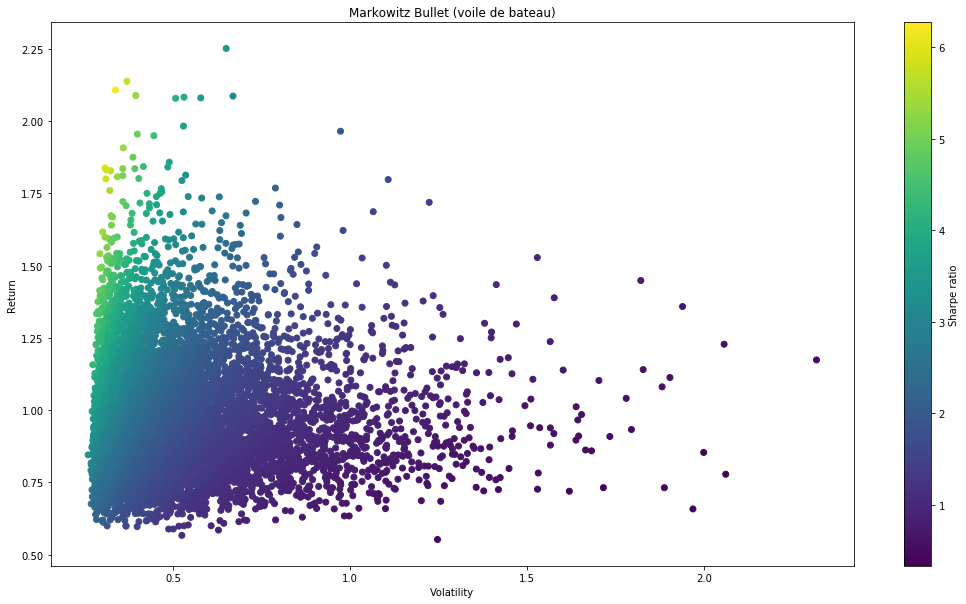

In [22]:
import matplotlib.pyplot as plt

#FIXME pourquoi notre volatilité est très haute et notre rendement est faible ?
#FIXME il faudrait imposer les contraintes du sujet aux portfolios générés (ex: nav 1 et 15%, stock > 50%, ...)
def get_Markowitz_Bullet(begin_date, end_date, best_weights=None, assets=None, iterations=10000):
    if assets is None:
        assets = get_df_asset(begin_date, df_currency_rate)
        assets = assets[assets['TYPE'] != 'PORTFOLIO']
    assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]
    
    #dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
    df_ratios = get_df_ratios(assets_id, begin_date, end_date)
    assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID')
    
    portfolio_returns = []
    portfolio_volatilities = []
    portfolio_sharpes = []
    
    returns = assets['rendement'].values
    volatilities = assets['volatilite'].values
    sharpes = assets['sharpe'].values
    
    for i in range(iterations):
        weights = np.random.dirichlet(np.ones(assets.shape[0]), size=1)
        
        weights = weights[0]
        
        total_returns = np.dot(returns, weights)
        total_volatilities = np.dot(volatilities, weights)
        #total_sharpes = np.dot(sharpes, weights)
        
        rates_returns = (1 + returns)**(365/1582) - 1

        portfolio_sharpes.append((np.sum(rates_returns) - 0.05)/np.sum(total_volatilities))
        #print((np.sum(taux_returns) - 0.05)/np.sum(total_volatilities))
        #print(-(taux_returns - 0.05)/np.dot(volatilities, weights))
        
        portfolio_returns.append(total_returns)
        portfolio_volatilities.append(total_volatilities)
        #portfolio_sharpes.append(total_sharpes)
        
    portfolio_returns = np.array(portfolio_returns)
    portfolio_volatilities = np.array(portfolio_volatilities)
    
    plt.figure(figsize=(18,10))
    plt.scatter(portfolio_volatilities, portfolio_returns, c = portfolio_returns/portfolio_volatilities)
                #c=(portfolio_sharpes)) #FIXME
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe ratio')
    plt.title('Markowitz Bullet (voile de bateau)')
    
    if best_weights is not None:
        best_portfolio_returns = np.dot(returns, best_weights)
        best_portfolio_volatilies = np.dot(volatilities, best_weights)
        best_sharpe = best_portfolio_returns / best_portfolio_volatilies
        plt.scatter(best_portfolio_volatilies, best_portfolio_returns, c='red', marker='+', s=[500])

        print('Best portfolio have a sharpe ratio = {}'.format(best_sharpe))
    
    #return assets

get_Markowitz_Bullet('2016-06-01', '2020-09-30')

In [23]:
def portfolio_stats(assets, weights):
    returns = assets['rendement'].values
    volatilities = assets['volatilite'].values
    #sharpes = assets['sharpe'].values

    total_returns = np.dot(returns, weights) #FIXME
    total_volatilities = np.dot(volatilities, weights) #FIXME

    #rates_returns = (1 + returns)**(365/1582) - 1
    #portfolio_sharpes.append((np.sum(rates_returns) - 0.05)/np.sum(total_volatilities))

    total_sharpes = total_returns / total_volatilities #FIXME
    
    return {'return': total_returns, 'volatility': total_volatilities, 'sharpe': total_sharpes}

Minimization Functions

In [24]:
def minimize_sharpe(weights, assets):#on veut maximiser sharpe
    return -portfolio_stats(assets, weights)['sharpe'] 

"""def minimize_volatility(weights, assets):#on veut minimiser volatilite
    return portfolio_stats(assets, weights)['volatility']

def minimize_return(weights, assets):#on veut maximiser return
    return -portfolio_stats(assets, weights)['return']"""

"def minimize_volatility(weights, assets):#on veut minimiser volatilite\n    return portfolio_stats(assets, weights)['volatility']\n\ndef minimize_return(weights, assets):#on veut maximiser return\n    return -portfolio_stats(assets, weights)['return']"

The Optimization Function

In [25]:
def optimize_sharpe(assets):
    nb_assets = assets.shape[0]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 0.15) for x in range(nb_assets)) #FIXME entre 0 et 0.15 pas pour les weights
    #mais pour le nav => 0 <= (w * close) / sum (w * close ) de tous les assets <= 0.15
    #puis on delete tous les w entre 0 et 0.01
    #ps: pour sum (w * close), sum (w) = 1
    initializer = nb_assets * [1 / nb_assets]
    
    best_sharpe = optimize.minimize(minimize_sharpe, initializer, (assets), method='SLSQP', bounds=bounds, constraints=constraints)
    return best_sharpe.x

In [26]:
assets = get_df_asset('2016-06-01', df_currency_rate)
assets = assets[assets['TYPE'] != 'PORTFOLIO']
assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]

#dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
df_ratios = get_df_ratios(assets_id, '2016-06-01', '2020-09-30')
assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID')

weights = optimize_sharpe(assets).round(4)
weights

array([0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e

Best portfolio have a sharpe ratio = 54.93961904174006


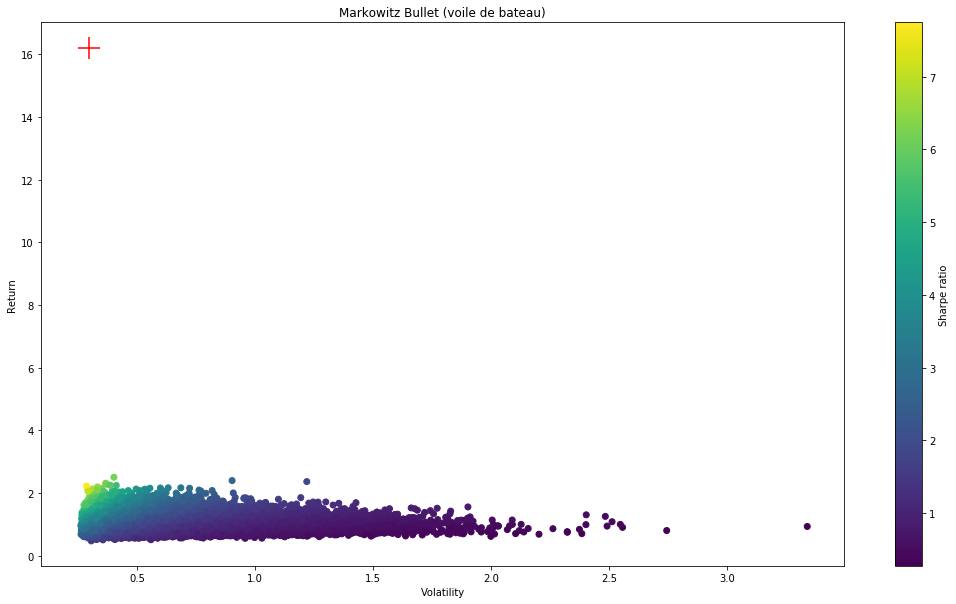

In [27]:
get_Markowitz_Bullet('2016-06-01', '2020-09-30', best_weights=weights, iterations=100000)

In [28]:
np.sum(weights)

1.0000999999999998

In [29]:
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats

def check_stock_percent_in_assets(assets):
    nb_stocks = assets[assets['TYPE'] == 'STOCK'].shape[0]
    nb_assets = assets.shape[0]
    
    if (nb_stocks / nb_assets) < 0.5:
        print('Error: not enough stock assets !')
        
def check_and_fix_nav_assets(assets, weights):
    sum_nav = 0
    values = assets['LAST_CLOSE_VALUE_IN_CURR'].values
    
    n = len(weights)
    for i in range(n):
        #print(weights[i])
        weights[i] = round(weights[i]*100)#FIXME
        #print(weights[i])
        nav = values[i] * weights[i] #FIXME A CHECK
        sum_nav += nav
    for i in range(n):
        print(values[i])
        print(weights[i])
        nav = values[i] * weights[i]
        nav_asset_part_portfolio = nav / sum_nav
        print('id : {} nav {}'.format(assets['ASSET_DATABASE_ID'].values[i], nav_asset_part_portfolio))

        while nav_asset_part_portfolio < 0.01 or nav_asset_part_portfolio > 0.1:
            nav = values[i] * weights[i]            
            sum_nav -= nav
            
            weights[i] = round(weights[i] * 4.5 / nav_asset_part_portfolio)#FIXME POURQUOI 4.5 ?
            
            nav = values[i] * weights[i]
            sum_nav += nav
            
            nav_asset_part_portfolio = nav / sum_nav
    return weights

def select_best_assets(begin_date, end_date, df_current_rate):
    assets = get_df_asset(begin_date, df_currency_rate)
    #remove portfolios from assets
    assets = assets[assets['TYPE'] != 'PORTFOLIO']
    assets_id = [int(asset_id) for asset_id in assets['ASSET_DATABASE_ID'].values]
    
    #dataframe de tous les ratio 12 Sharpe 13 Rendement 10 Volatile pour chaque assets
    df_ratios = get_df_ratios(assets_id, begin_date, end_date)
    assets = assets.merge(df_ratios, on='ASSET_DATABASE_ID')

    weights = optimize_sharpe(assets).round(4).tolist()
    
    nb_assets = len(assets_id)
    df_assets_weights = pd.DataFrame([(assets_id[i], weights[i]) for i in range(nb_assets)], columns=['ASSET_DATABASE_ID', 'weights'])
    assets = assets.merge(df_assets_weights, on='ASSET_DATABASE_ID')
    
    assets_selected = assets[assets['weights'] != 0]
    
    check_stock_percent_in_assets(assets)#check si stock actifs >= 50%
    
    #CHECK MINIMUM QUANTITY
    #weights = check_and_fix_nav_assets(assets, weights)
    
    #print(np.sum(weights))
    return assets_selected

select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)

,index,LABEL,ASSET_DATABASE_ID,TYPE,LAST_CLOSE_VALUE_IN_CURR,CREATION_DATE,volatilite,rendement,sharpe,weights
184,195,CHARGEURS SA,1956,STOCK,9.770000000000,2019-10-02,0.316526505697,9.760593587509,0.287942929878,0.1500
207,218,CPR CROISSANCE PRUDENTE I FCP,1485,FUND,125626.899999999994,2019-08-16,0.115409709856,1.826589694827,0.311610895119,0.1500
210,222,CRCAM DU LANGUED,1971,STOCK,57.000000000000,2019-10-02,0.153935069941,3.098364800064,0.331391851407,0.1500
238,252,DEVOTEAM SA,1990,STOCK,43.000000000000,2019-10-02,0.345748342065,13.277449574933,0.298436008753,0.1500
279,293,EONIA Total Return Index,1521,INDEX,140.859900000000,2019-08-16,0.079178303741,0.061184398139,-0.034136955142,0.0543
291,306,EUROFINS-CEREP REGRP,2024,STOCK,100.000000000000,2019-10-02,0.552076326474,68.629619541819,0.313627858417,0.1500
364,381,INTESA SANPAOLO,1583,STOCK,2.270000000000,2019-08-16,99.087471921970,0.920464988005,0.000207226212,0.0001
375,392,LBPAM-EON 3-6-I,1597,FUND,10322.150000000000,2019-08-16,0.086781935519,0.357305165802,0.079203891322,0.0457
399,416,NVIDIA CORP,2112,STOCK,39.845080013607,2019-10-02,0.359248131650,11.182914929190,0.268371159516,0.1500


In [30]:
assets_selected = select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)

In [31]:
def post_assets_selected_in_portfolio(assets, begin_date, df_currency_rate):
    """asset['weights']"""
    assets_id_quantity = [{"asset": {"asset": asset['ASSET_DATABASE_ID'], "quantity": 10000}} for _, asset in assets.iterrows()]
    print(assets_id_quantity)
    df_assets = df_convert_type(pd.read_json(get_data('asset/')), df_currency_rate)
    
    portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
    df_portfolio = get_portfolio(portfolio_id)
    
    reset_assets_portfolio(portfolio_id, df_portfolio)#on reset le contenu du portfolio (plus safe)
    
    df_portfolio = get_portfolio(portfolio_id)
    put_portfolio(portfolio_id, df_portfolio, assets_id_quantity)
    
#assets_selected = select_best_assets('2016-06-01', '2020-09-30', df_currency_rate)
post_assets_selected_in_portfolio(assets_selected, '2016-06-01', df_currency_rate)

[{'asset': {'asset': 1956, 'quantity': 10000}}, {'asset': {'asset': 1485, 'quantity': 10000}}, {'asset': {'asset': 1971, 'quantity': 10000}}, {'asset': {'asset': 1990, 'quantity': 10000}}, {'asset': {'asset': 1521, 'quantity': 10000}}, {'asset': {'asset': 2024, 'quantity': 10000}}, {'asset': {'asset': 1583, 'quantity': 10000}}, {'asset': {'asset': 1597, 'quantity': 10000}}, {'asset': {'asset': 2112, 'quantity': 10000}}]
{'label': 'EPITA_PTF_10', 'currency': {'code': 'EUR'}, 'type': 'front', 'values': {'2016-06-01': [{'asset': {'asset': 1956, 'quantity': 10000}}, {'asset': {'asset': 1485, 'quantity': 10000}}, {'asset': {'asset': 1971, 'quantity': 10000}}, {'asset': {'asset': 1990, 'quantity': 10000}}, {'asset': {'asset': 1521, 'quantity': 10000}}, {'asset': {'asset': 2024, 'quantity': 10000}}, {'asset': {'asset': 1583, 'quantity': 10000}}, {'asset': {'asset': 1597, 'quantity': 10000}}, {'asset': {'asset': 2112, 'quantity': 10000}}]}}


Comparaison du ratio de sharpe entre notre portefeuille et le portefeuille de référence : 

In [32]:
def compare_portfolios(our_portfolio_id, ref_portfolio_id, begin_date, end_date):    
    ratios = json.loads(post_ratio([12], [our_portfolio_id, ref_portfolio_id], begin_date, end_date))
    print('sharpe ratio in our portfolio : {}\nsharpe ratio in ref portfolio : {}'
          .format(ratios[str(our_portfolio_id)]['12']['value'], ratios[str(ref_portfolio_id)]['12']['value']))
    
our_portfolio_id = get_portfolio_id(df_assets, 'EPITA_PTF_10')
ref_portfolio_id = get_portfolio_id(df_assets, 'REF')
compare_portfolios(our_portfolio_id, ref_portfolio_id, '2016-06-01', '2020-09-30')

sharpe ratio in our portfolio : Aucune donnée disponible (pas de donnée d'actif Erreur causée par "EPITA_PTF_10")
sharpe ratio in ref portfolio : 0,386697534093


In [33]:
our_portfolio = get_portfolio(our_portfolio_id)
print(our_portfolio.values)
our_portfolio

[['EPITA_PTF_10' 'EUR' 'front' nan]
 ['EPITA_PTF_10' nan 'front'
  list([{'asset': {'asset': 2112, 'quantity': 10000.0}}, {'asset': {'asset': 1521, 'quantity': 10000.0}}, {'asset': {'asset': 1971, 'quantity': 10000.0}}, {'asset': {'asset': 1956, 'quantity': 10000.0}}, {'asset': {'asset': 1990, 'quantity': 10000.0}}, {'asset': {'asset': 2024, 'quantity': 10000.0}}, {'asset': {'asset': 1485, 'quantity': 10000.0}}, {'asset': {'asset': 1597, 'quantity': 10000.0}}, {'asset': {'asset': 1583, 'quantity': 10000.0}}])]]


,label,currency,type,values
code,EPITA_PTF_10,EUR,front,NaN
2016-06-01,EPITA_PTF_10,NaN,front,"[{'asset': {'asset': 2112, 'quantity': 10000.0..."


In [34]:
ref_portfolio = get_portfolio(ref_portfolio_id)
print(ref_portfolio.values)
ref_portfolio

[['REF' 'EUR' 'front' nan]
 ['REF' nan 'front'
  list([{'asset': {'asset': 2112, 'quantity': 18000.0}}, {'asset': {'asset': 2144, 'quantity': 2000.0}}, {'asset': {'asset': 2064, 'quantity': 5000.0}}, {'asset': {'asset': 1968, 'quantity': 90000.0}}, {'asset': {'asset': 1585, 'quantity': 7000.0}}, {'asset': {'asset': 2132, 'quantity': 110.0}}, {'asset': {'asset': 1990, 'quantity': 20000.0}}, {'asset': {'asset': 1897, 'quantity': 35000.0}}, {'asset': {'asset': 2105, 'quantity': 2200.0}}, {'asset': {'asset': 2013, 'quantity': 10000.0}}, {'asset': {'asset': 2142, 'quantity': 650.0}}, {'asset': {'asset': 2143, 'quantity': 420.0}}])]]


,label,currency,type,values
code,REF,EUR,front,NaN
2013-06-14,REF,NaN,front,"[{'asset': {'asset': 2112, 'quantity': 18000.0..."


TODO:

Corriger le calcul du rendement, de la volatilité et du ratio de sharpe

Gérér le nav du portfolio (entre 1 et 15%)

Gérér les quantités des actifs (des entiers et checker la quantité minimum requise pour chaque actif